# Define a simple bipartite graph

This is modelling a collection of sets that include different parts from a common pool.

In [1]:
sets = ['a', 'b', 'c', 'd']
parts = [1, 2, 3]
edges = [('a', 1), ('a', 2), ('b', 2), ('b', 3), ('c', 3), ('b', 1)]

# NetworkX methods

NetworkX is pure python and simple to run in a notebook and instantiate from collections of Python types.

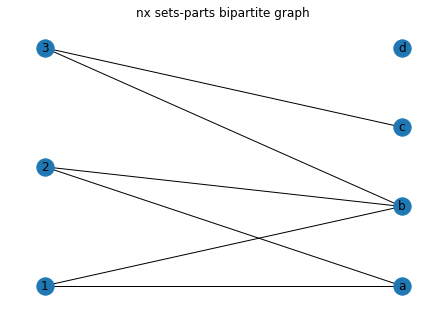

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

nx_B = nx.Graph()
nx_B.add_nodes_from(sets, bipartite=0)
nx_B.add_nodes_from(parts, bipartite=1)
nx_B.add_edges_from(edges)

nx_posb = nx.bipartite_layout(nx_B, parts)
nx.draw(nx_B, pos=nx_posb, with_labels=True)
plt.title('nx sets-parts bipartite graph')
plt.show()

NetworkX also supports bipartite projections

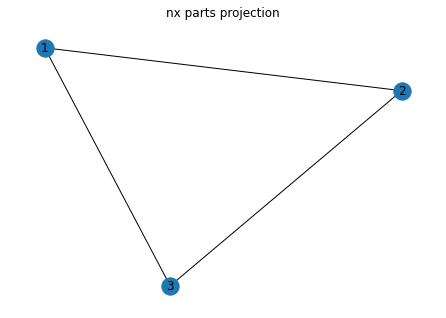

In [3]:
from networkx.algorithms import bipartite

nx_projection_parts = bipartite.projected_graph(nx_B, parts)
nx.draw(nx_projection_parts, with_labels=True)
plt.title('nx parts projection')
plt.show()

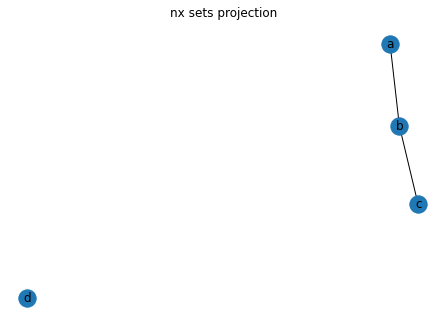

In [4]:
nx_projection_sets = bipartite.projected_graph(nx_B, sets)
nx.draw(nx_projection_sets, with_labels=True)
plt.title('nx sets projection')
plt.show()

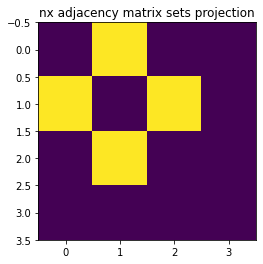

In [5]:
nx_A = nx.adjacency_matrix(nx_projection_sets).toarray()
plt.imshow(nx_A)
plt.title('nx adjacency matrix sets projection')
plt.show()

#  graph_tool install

graph_tool is implemented in C++ and hence much faster at processing bigger graphs. However, it takes a little more setup to run in a notebook environment like colab. This section gets graph_tool set up.

In [6]:
%%capture
!apt-get install libcairo2-dev 
!pip install pycairo

In [7]:
%%capture
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib
!ln -s /usr/lib/python3/dist-packages/gi/_gi.cpython-{36m,37m}-x86_64-linux-gnu.so

# graph_tool define graph

graph_tool defines graphs from vertex indexes, so other collections of other Python types are supported through vertex properties. Here we define in graph_tool the same bipartite graph as above, and give each indexed vertex a name based on its node object.

In [8]:
import graph_tool.all as gt

In [9]:
def gt_graph(sets, parts, edges):
  vertex_names = list(sets)
  vertex_names.extend([str(p) for p in parts])
  vbn = {v : i for i, v in enumerate(vertex_names)}
  edges_ids = [(vbn[e[0]], vbn[str(e[1])]) for e in edges]
  
  g = gt.Graph(directed=False)
  g.add_vertex(len(vertex_names))
  g.properties[('v', 'name')] = g.new_vp('string', vals=vertex_names)
  g.add_edge_list(edges_ids)
  return g

In [10]:
gt_B = gt_graph(sets, parts, edges)
is_bipartite, partition = gt.is_bipartite(gt_B, partition=True)
is_bipartite

True

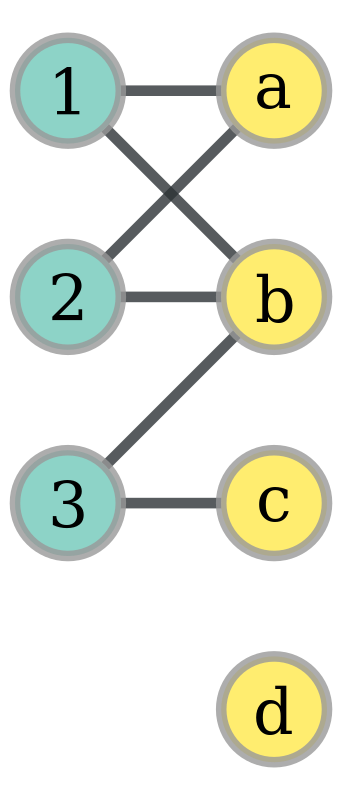

In [11]:
pos_prop = gt_B.new_vertex_property("vector<double>")
for i in range(gt_B.num_vertices()):
  pos_prop[i] = (partition[i], i % len(sets))

gt.graph_draw(gt_B,
              pos=pos_prop,
              vertex_text=gt_B.vp['name'],
              vertex_fill_color=partition,
              output_size=(600, 400))
plt.show()

# Bipartite projection for graph_tool

I want an efficient bipartite projection for large graphs that I can use from Python, but at time of writing, graph_tool doesn't support bipartite projection. I figured I could implement the projection with numpy.

This section implements in numpy the (dense adjacency) matrix multiplication bipartite projection algorithm described in [Algorithms for projecting a bipartite network](https://www.researchgate.net/publication/323067832_Algorithms_for_projecting_a_bipartite_network) (Banerjee
and Jenamani).

In [12]:
import numpy as np

def bipartite_projection_biadjacency(biadj):
  n1 = biadj.shape[0]
  prod = np.matmul(biadj, biadj.T)
  prod[np.diag_indices(n1)] = 0
  return prod > 0

The biadjacency matrix is the upper corner of the full adjacency matrix for a bipartite graph, as described in https://en.wikipedia.org/wiki/Adjacency_matrix.

In [13]:
# n1 is the number of vertexes in partition label 1
# partition_label is 1 or 0
# assume all vertexes in partition 1 precede partition 0

def gt_biadjacency(g, n1, partition_label=1):
  n2 = g.num_vertices() - n1
  adj = gt.adjacency(g).toarray()
  biadj = adj[:n1, n2+1:]
  return biadj if partition_label else biadj.T

graph_tool implements multi-graph by default

In [14]:
def gt_simple_graph_from_adjacency(adj):
  n = adj.shape[0]
  adju = np.array(adj)
  adju[np.tril_indices(n)] = 0
  graph = gt.Graph(directed=False)
  graph.add_vertex(n)
  graph.add_edge_list(np.argwhere(adju > 0))
  return graph

This combines the component methods

In [15]:
def gt_bipartite_projection(g, n1, partition_label=1):
  biadj = gt_biadjacency(g, n1, partition_label)
  proj_adj = bipartite_projection_biadjacency(biadj)
  proj = gt_simple_graph_from_adjacency(proj_adj)
  g_vn = list(g.vp['name'])
  proj_vertex_names = g_vn[:n1] if partition_label else g_vn[n1:]
  proj.properties[('v', 'name')] = proj.new_vp('string', vals=proj_vertex_names)
  return proj

Inspect results step-by-step

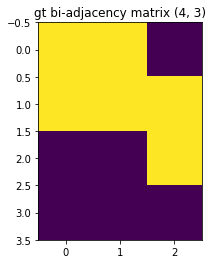

In [16]:
gt_biadj_sets = gt_biadjacency(gt_B, len(sets), partition_label=1)
plt.imshow(gt_biadj_sets)
plt.title(f'gt bi-adjacency matrix {gt_biadj_sets.shape}')
plt.show()

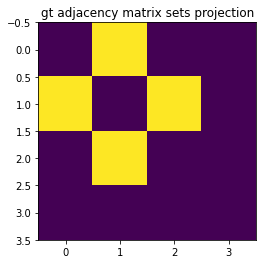

In [17]:
gt_proj_sets = bipartite_projection_biadjacency(gt_biadj_sets)
plt.imshow(gt_proj_sets)
plt.title(f'gt adjacency matrix sets projection')
plt.show()

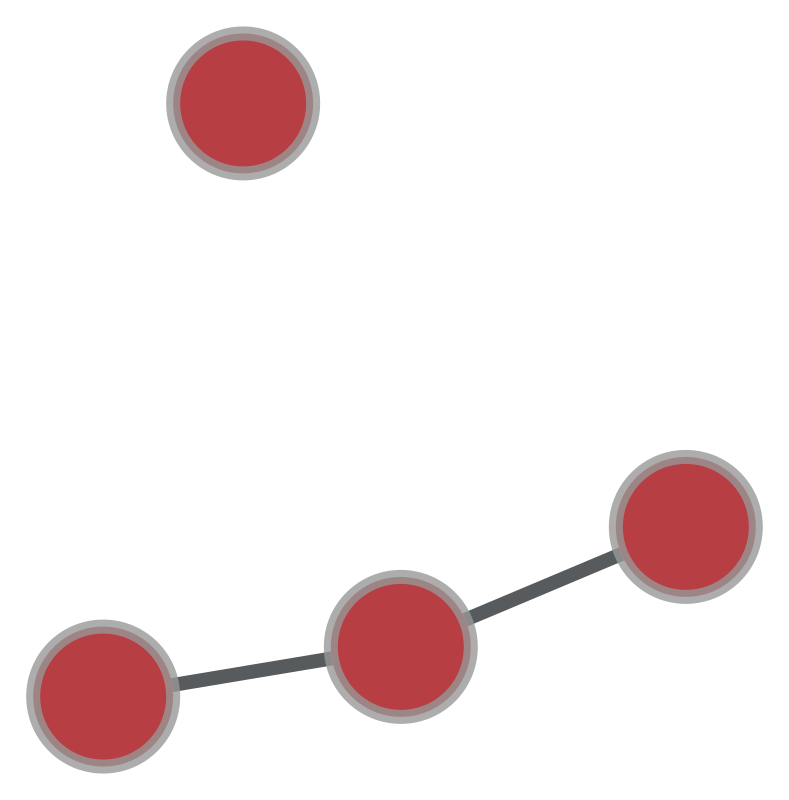

In [18]:
gt_proj_graph_sets = gt_simple_graph_from_adjacency(gt_proj_sets)
gt.graph_draw(gt_proj_graph_sets, output_size=(600, 400))
plt.show()

Test projections on both partitions end to end

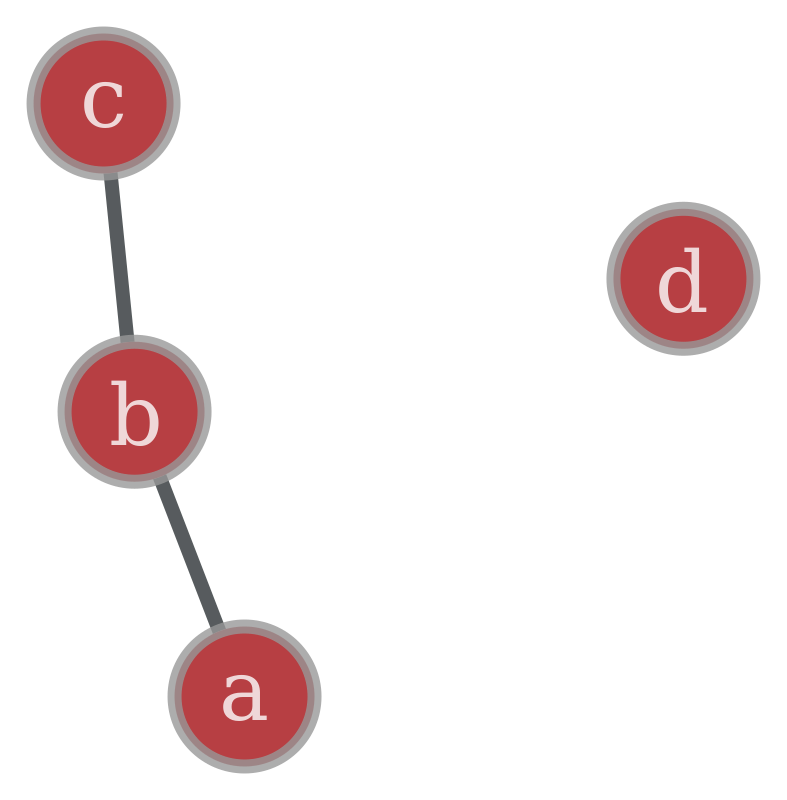

In [19]:
e2e_sets = gt_bipartite_projection(gt_B, len(sets), partition_label=1)
gt.graph_draw(e2e_sets, vertex_text=e2e_sets.vp['name'], output_size=(600, 400))
plt.show()

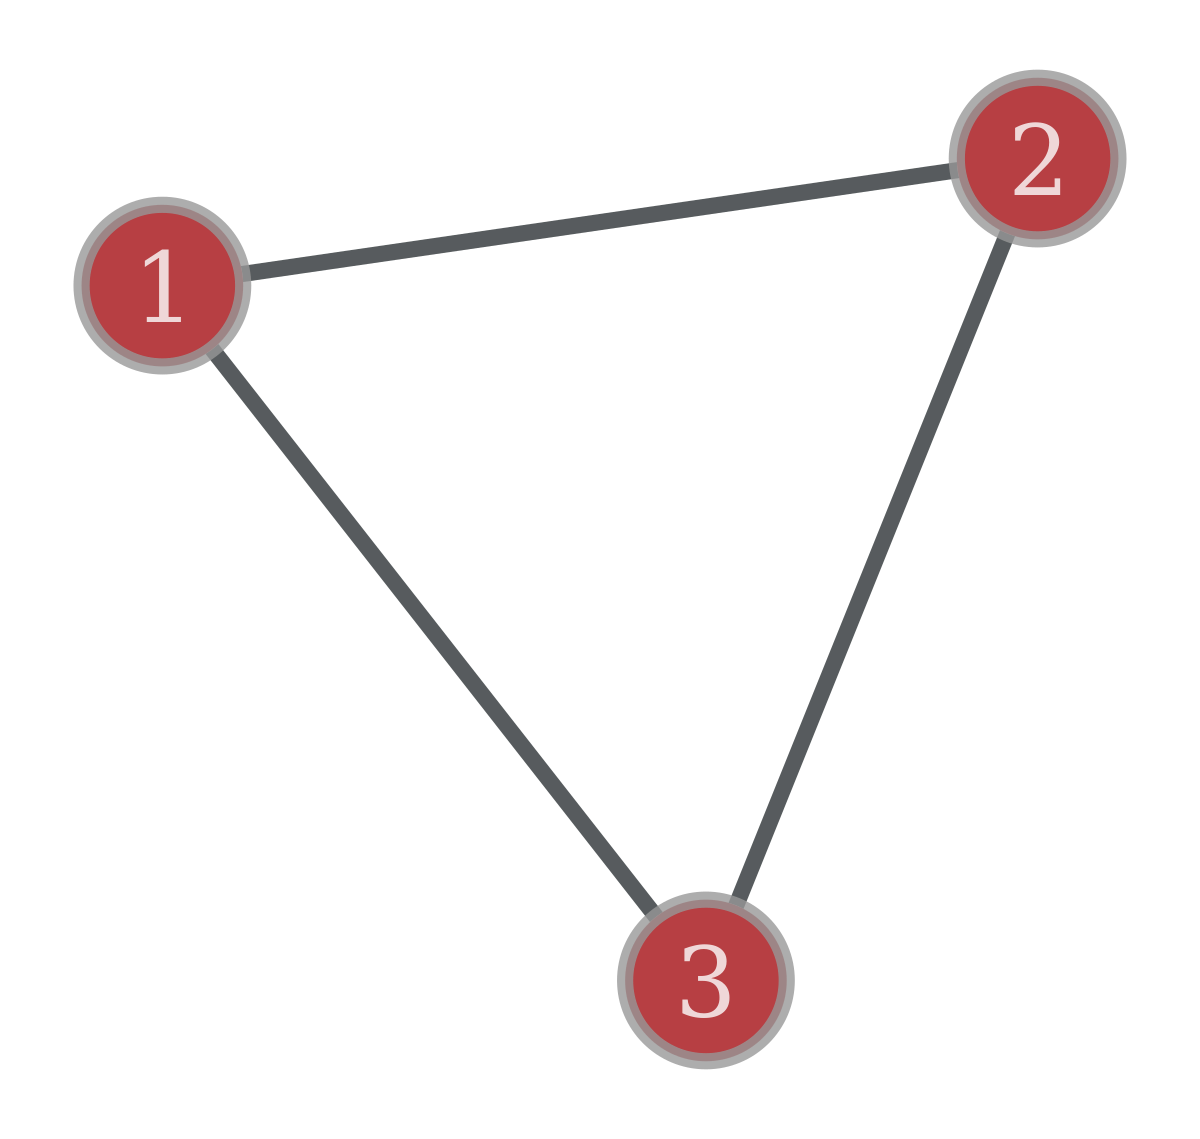

In [20]:
e2e_parts = gt_bipartite_projection(gt_B, len(sets), partition_label=0)
gt.graph_draw(e2e_parts, vertex_text=e2e_parts.vp['name'], output_size=(600, 400))
plt.show()